In [5]:
import sys

sys.path.append('/home/radlr/anaconda3/envs/lVGPU2/lib/python3.6/site-packages')

In [6]:
# math etc.
from scipy import misc
import numpy as np

#plotting
import matplotlib as mpl
from matplotlib import pyplot as plt

#image functions, esp. resizing
import cv2
#directory functions
import os

In [ ]:
def cuttleVision(cSpher,fN,nStk,off,defAtt):
    img = 1.0*misc.imread(fN)
    sBNarrower = 1.0*misc.imread('./sBandiensisNarrower-1.tif')
    sBNarrow = 1.0*misc.imread('./sBandiensisNarrow-1.tif')
    sBFull = 1.0*misc.imread('./sBandiensisFuller-1.tif')
    
    dimX = np.shape(sBNarrower)[0]
    mid = dimX/2
    dimImg = np.shape(img)[0]
    
    N = 12.5 #25mm eye
    x1, y1 = np.meshgrid(np.arange(-N,N-N/dimX,2*N/dimX),np.arange(-N,N-N/dimX,2*N/dimX))
    
    rad = np.sqrt(x1**2+y1**2)
    
    apDef = np.exp(np.sqrt(3)*(2*rad**2-1))
    apSpher = np.exp(np.sqrt(5) * (6*rad**4 - 6*rad**2+1))
    
    nStk = 2 # three focus depths
    
    
    imgStack = np.zeros([dimImg,dimImg,3])
    
    myPSFDim = 48
    PSF = np.zeros([myPSFDim*2,myPSFDim*2,9])
    
    for c in range(0,nStk+1):
        
        cChromR = 1 - (c / (nStk))
        cChromB = 1.0 - cChromR
        cChromG = 0.5 - cChromR
        if (0):
            apR1 = (sBNarrow) * np.exp(1j*2*np.pi*(cChromR/defAtt*apDef+cSpher*apSpher));
            apG1 = (sBNarrow) * np.exp(1j*2*np.pi*(cChromG/defAtt*apDef+cSpher*apSpher));
            apB1 = (sBNarrow) * np.exp(1j*2*np.pi*(cChromB/defAtt*apDef+cSpher*apSpher));
        if(1):
            apR1 = (sBFull) * np.exp(1j*2*np.pi*(cChromR/defAtt*apDef+cSpher*apSpher));
            apG1 = (sBFull) * np.exp(1j*2*np.pi*(cChromG/defAtt*apDef+cSpher*apSpher));
            apB1 = (sBFull) * np.exp(1j*2*np.pi*(cChromB/defAtt*apDef+cSpher*apSpher));
        
        apR1 = np.nan_to_num(apR1)
        apG1 = np.nan_to_num(apG1)
        apB1 = np.nan_to_num(apB1)
                
        PSF1R = np.abs(np.fft.fft2(apR1))**2
        PSF1G = np.abs(np.fft.fft2(apG1))**2
        PSF1B = np.abs(np.fft.fft2(apB1))**2
        
        #normalize PSFs
        if (0):
            PSF1R = PSF1R/np.max(np.max(PSF1R)); #%abs(fft(apR1)).^2;
            PSF1G = PSF1G/np.max(np.max(PSF1G));
            PSF1B = PSF1B/np.max(np.max(PSF1B));
        
        tempR = np.abs(np.fft.ifft2(np.fft.fft2(img[:,:,0],[dimX,dimX])*np.fft.fft2(PSF1R)))
        tempG = np.abs(np.fft.ifft2(np.fft.fft2(img[:,:,1],[dimX,dimX])*np.fft.fft2(PSF1G)))
        tempB = np.abs(np.fft.ifft2(np.fft.fft2(img[:,:,2],[dimX,dimX])*np.fft.fft2(PSF1B)))
        
        tempR = (tempR - np.min(tempR)) / np.max(tempR)
        tempG = (tempG - np.min(tempG)) / np.max(tempG)
        tempB = (tempB - np.min(tempB)) / np.max(tempB)
        
        tempR = tempR[0:dimImg,0:dimImg]
        tempG = tempG[0:dimImg,0:dimImg]
        tempB = tempB[0:dimImg,0:dimImg]
        
        myPSFDim = 48
        PSF1R = np.fft.fftshift(PSF1R)[int(dimX/2)-myPSFDim:int(dimX/2)+myPSFDim,int(dimX/2)-myPSFDim:int(dimX/2)+myPSFDim]
        PSF1G = np.fft.fftshift(PSF1G)[int(dimX/2)-myPSFDim:int(dimX/2)+myPSFDim,int(dimX/2)-myPSFDim:int(dimX/2)+myPSFDim]
        PSF1B = np.fft.fftshift(PSF1B)[int(dimX/2)-myPSFDim:int(dimX/2)+myPSFDim,int(dimX/2)-myPSFDim:int(dimX/2)+myPSFDim]
        
        imgStack[:,:,c] = tempR + tempG + tempB
        if(0):
            imgStack[:,:,c*3+0] = tempR
            imgStack[:,:,c*3+1] = tempG
            imgStack[:,:,c*3+2] = tempB
        if(1):
            PSF[:,:,c*3+0] = PSF1R
            PSF[:,:,c*3+1] = PSF1G
            PSF[:,:,c*3+2] = PSF1B
        if (0): #plot for debugging/testing defocus parameters
            plt.figure(figsize=(12,12))
            plt.subplot(321)
            plt.imshow(tempR,cmap='gray')
            plt.subplot(322)
            plt.imshow(tempG,cmap='gray')
            plt.subplot(323)
            plt.imshow(tempB,cmap='gray')
            #plt.figure()
            #plt.imshow(PSF1R)
            plt.show()
            myImgRGB = np.zeros([dimImg,dimImg,3])
            myImgRGB[:,:,0] = tempR
            myImgRGB[:,:,1] = tempG
            myImgRGB[:,:,2] = tempB
            plt.figure(figsize=(6,6))
            plt.imshow(myImgRGB)
            #plt.figure()
            #plt.imshow(PSF1R)
            plt.show()
    return imgStack, PSF

In [2]:
myDir = os.listdir('./imgs/')
print(np.shape(myDir))
myResDim = 384
for c in myDir:
    print(c)
    myImg = cv2.imread('./imgs/' + str(c))
    myDimX = np.shape(myImg)[0]
    myDimY = np.shape(myImg)[1]
    if (myDimX < myDimY):
        myDim = myDimX
    else:
        myDim = myDimY
    myImg = myImg[0:myDim,0:myDim,:]
    myResImg = cv2.resize(myImg,(myResDim,myResDim), interpolation = cv2.INTER_CUBIC)
    if(0):
        plt.figure()
        plt.imshow(myImg)
        plt.show()
        plt.figure()
        plt.imshow(myResImg)
        plt.show()
    cv2.imwrite('./miniImgs/mini'+str(c)[0:int(len(c)-4)]+'.tif',myResImg)
    
    
if (0):
    fN = './imgs/Sea_Cotton.jpg'
    myImg = cv2.imread(fN)
    myImg = myImg[0:624,0:624]
    myImg2 = cv2.resize(myImg,None,fx=1/2, fy=1/2, interpolation = cv2.INTER_CUBIC)

    plt.figure()
    plt.imshow(myImg)
    plt.figure()
    plt.imshow(myImg2)
    plt.show()
    cv2.imwrite('minSea_Cotton.png',myImg2)

NameError: name 'os' is not defined

miniGOPR9349.tif


/home/main/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: RuntimeWarning: overflow encountered in exp
/home/main/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:17: RuntimeWarning: overflow encountered in exp
/home/main/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:37: RuntimeWarning: invalid value encountered in multiply
/home/main/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:38: RuntimeWarning: invalid value encountered in multiply
/home/main/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:39: RuntimeWarning: invalid value encountered in multiply


(1, 384, 384, 3)
(1, 384, 384, 3)
miniGOPR9352.tif
(2, 384, 384, 3)
(2, 384, 384, 3)
miniG0369051.tif
(3, 384, 384, 3)
(3, 384, 384, 3)
miniGOPR9059.tif
(4, 384, 384, 3)
(4, 384, 384, 3)
miniG0338961.tif
(5, 384, 384, 3)
(5, 384, 384, 3)
miniGOPR9072.tif
(6, 384, 384, 3)
(6, 384, 384, 3)
miniGOPR9322.tif
(7, 384, 384, 3)
(7, 384, 384, 3)
miniGOPR9050.tif
(8, 384, 384, 3)
(8, 384, 384, 3)
miniGOPR9039.tif
(9, 384, 384, 3)
(9, 384, 384, 3)
miniGOPR9336.tif
(10, 384, 384, 3)
(10, 384, 384, 3)
miniGOPR9340.tif
(11, 384, 384, 3)
(11, 384, 384, 3)
miniGOPR9339.tif
(12, 384, 384, 3)
(12, 384, 384, 3)
miniGOPR9106.tif
(13, 384, 384, 3)
(13, 384, 384, 3)
miniGOPR9069.tif
(14, 384, 384, 3)
(14, 384, 384, 3)
miniGOPR9013.tif
(15, 384, 384, 3)
(15, 384, 384, 3)
miniGOPR9110.tif
(16, 384, 384, 3)
(16, 384, 384, 3)
miniGOPR9027.tif
(17, 384, 384, 3)
(17, 384, 384, 3)
miniGOPR9133.tif
(18, 384, 384, 3)
(18, 384, 384, 3)
miniGOPR9113.tif
(19, 384, 384, 3)
(19, 384, 384, 3)
miniGOPR9003.tif
(20, 384, 3

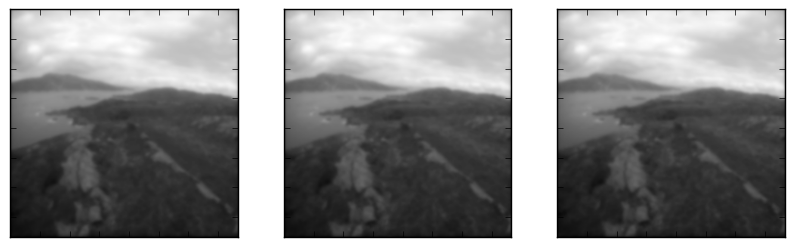

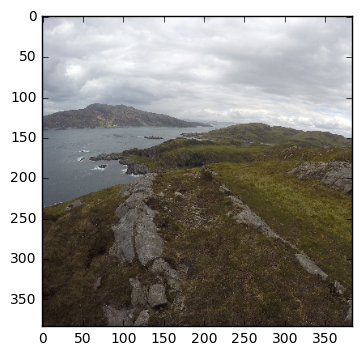

miniGOPR9041.tif
(26, 384, 384, 3)
(26, 384, 384, 3)
miniGOPR8997.tif
(27, 384, 384, 3)
(27, 384, 384, 3)
miniGOPR9329.tif
(28, 384, 384, 3)
(28, 384, 384, 3)
miniGOPR9015.tif
(29, 384, 384, 3)
(29, 384, 384, 3)
miniGOPR9358.tif
(30, 384, 384, 3)
(30, 384, 384, 3)
miniGOPR9029.tif
(31, 384, 384, 3)
(31, 384, 384, 3)
miniGOPR9043.tif
(32, 384, 384, 3)
(32, 384, 384, 3)
miniGOPR9090.tif
(33, 384, 384, 3)
(33, 384, 384, 3)
miniG0338957.tif
(34, 384, 384, 3)
(34, 384, 384, 3)
miniG0338959.tif
(35, 384, 384, 3)
(35, 384, 384, 3)
miniGOPR9105.tif
(36, 384, 384, 3)
(36, 384, 384, 3)
miniGOPR9026.tif
(37, 384, 384, 3)
(37, 384, 384, 3)
miniGOPR9319.tif
(38, 384, 384, 3)
(38, 384, 384, 3)
miniG0338967.tif
(39, 384, 384, 3)
(39, 384, 384, 3)
miniGOPR9001.tif
(40, 384, 384, 3)
(40, 384, 384, 3)
miniGOPR9344.tif
(41, 384, 384, 3)
(41, 384, 384, 3)
miniGOPR9346.tif
(42, 384, 384, 3)
(42, 384, 384, 3)
miniGOPR9007.tif
(43, 384, 384, 3)
(43, 384, 384, 3)
miniGOPR9037.tif
(44, 384, 384, 3)
(44, 384, 3

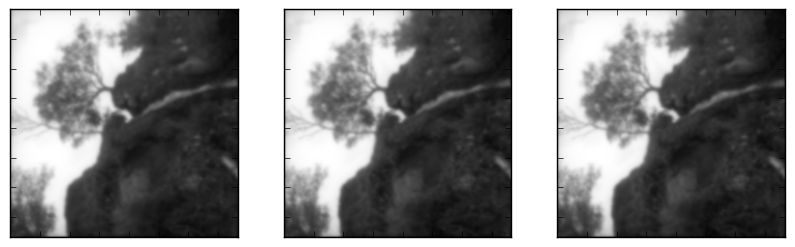

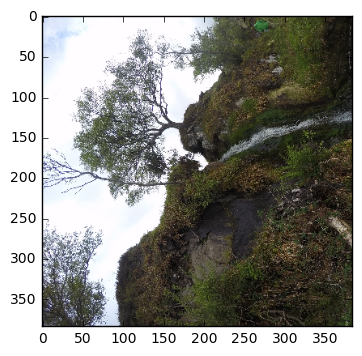

miniGOPR9128.tif
(51, 384, 384, 3)
(51, 384, 384, 3)
miniGOPR9066.tif
(52, 384, 384, 3)
(52, 384, 384, 3)
miniGOPR9012.tif
(53, 384, 384, 3)
(53, 384, 384, 3)
miniGOPR9021.tif
(54, 384, 384, 3)
(54, 384, 384, 3)
miniGOPR9067.tif
(55, 384, 384, 3)
(55, 384, 384, 3)
miniGOPR9022.tif
(56, 384, 384, 3)
(56, 384, 384, 3)
miniGOPR9044.tif
(57, 384, 384, 3)
(57, 384, 384, 3)
miniGOPR9354.tif
(58, 384, 384, 3)
(58, 384, 384, 3)
miniGOPR9116.tif
(59, 384, 384, 3)
(59, 384, 384, 3)
miniGOPR9112.tif
(60, 384, 384, 3)
(60, 384, 384, 3)
miniGOPR9081.tif
(61, 384, 384, 3)
(61, 384, 384, 3)
miniGOPR9017.tif
(62, 384, 384, 3)
(62, 384, 384, 3)
miniGOPR9321.tif
(63, 384, 384, 3)
(63, 384, 384, 3)
miniGOPR9334.tif
(64, 384, 384, 3)
(64, 384, 384, 3)
miniGOPR9080.tif
(65, 384, 384, 3)
(65, 384, 384, 3)
miniGOPR9077.tif
(66, 384, 384, 3)
(66, 384, 384, 3)
miniGOPR9132.tif
(67, 384, 384, 3)
(67, 384, 384, 3)
miniGOPR9327.tif
(68, 384, 384, 3)
(68, 384, 384, 3)
miniGOPR9355.tif
(69, 384, 384, 3)
(69, 384, 3

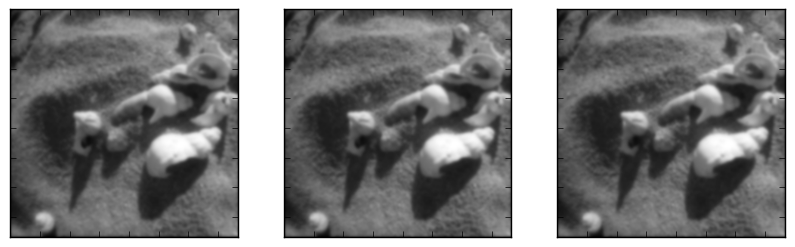

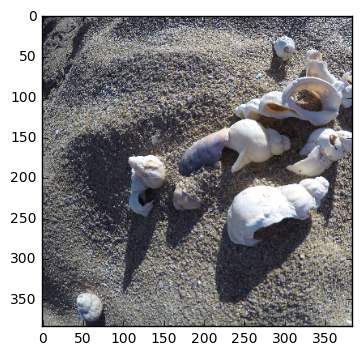

miniGOPR9063.tif
(76, 384, 384, 3)
(76, 384, 384, 3)
miniGOPR9348.tif
(77, 384, 384, 3)
(77, 384, 384, 3)
miniGOPR9095.tif
(78, 384, 384, 3)
(78, 384, 384, 3)
miniGOPR9046.tif
(79, 384, 384, 3)
(79, 384, 384, 3)
miniGOPR9335.tif
(80, 384, 384, 3)
(80, 384, 384, 3)
miniGOPR9326.tif
(81, 384, 384, 3)
(81, 384, 384, 3)
miniGOPR9092.tif
(82, 384, 384, 3)
(82, 384, 384, 3)
miniGOPR9347.tif
(83, 384, 384, 3)
(83, 384, 384, 3)
miniGOPR9325.tif
(84, 384, 384, 3)
(84, 384, 384, 3)
miniGOPR8998.tif
(85, 384, 384, 3)
(85, 384, 384, 3)
miniG0338958.tif
(86, 384, 384, 3)
(86, 384, 384, 3)
miniGOPR9071.tif
(87, 384, 384, 3)
(87, 384, 384, 3)
miniGOPR9096.tif
(88, 384, 384, 3)
(88, 384, 384, 3)
miniGOPR9079.tif
(89, 384, 384, 3)
(89, 384, 384, 3)
miniGOPR9337.tif
(90, 384, 384, 3)
(90, 384, 384, 3)
miniGOPR9097.tif
(91, 384, 384, 3)
(91, 384, 384, 3)
miniGOPR9086.tif
(92, 384, 384, 3)
(92, 384, 384, 3)
miniGOPR9020.tif
(93, 384, 384, 3)
(93, 384, 384, 3)
miniGOPR9357.tif
(94, 384, 384, 3)
(94, 384, 3

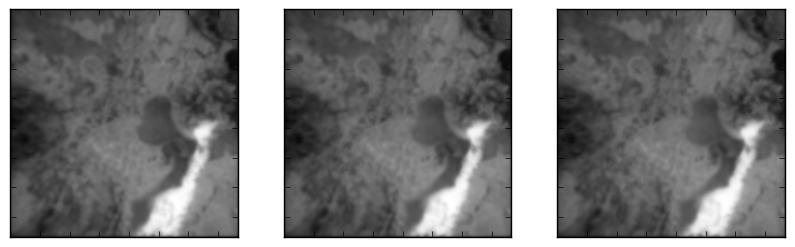

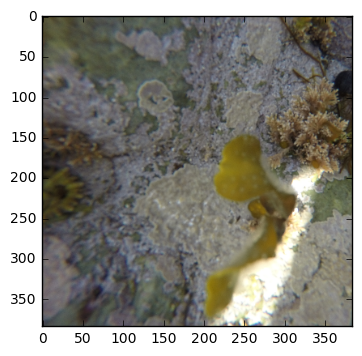

miniGOPR9045.tif
(101, 384, 384, 3)
(101, 384, 384, 3)
miniGOPR9006.tif
(102, 384, 384, 3)
(102, 384, 384, 3)
miniGOPR9360.tif
(103, 384, 384, 3)
(103, 384, 384, 3)
miniGOPR8995.tif
(104, 384, 384, 3)
(104, 384, 384, 3)
miniGOPR9042.tif
(105, 384, 384, 3)
(105, 384, 384, 3)
miniGOPR9061.tif
(106, 384, 384, 3)
(106, 384, 384, 3)
miniGOPR9332.tif
(107, 384, 384, 3)
(107, 384, 384, 3)
miniGOPR9353.tif
(108, 384, 384, 3)
(108, 384, 384, 3)
miniGOPR9091.tif
(109, 384, 384, 3)
(109, 384, 384, 3)
miniGOPR9350.tif
(110, 384, 384, 3)
(110, 384, 384, 3)
miniGOPR9117.tif
(111, 384, 384, 3)
(111, 384, 384, 3)
miniGOPR9104.tif
(112, 384, 384, 3)
(112, 384, 384, 3)
miniGOPR9131.tif
(113, 384, 384, 3)
(113, 384, 384, 3)
miniGOPR9035.tif
(114, 384, 384, 3)
(114, 384, 384, 3)
miniGOPR9004.tif
(115, 384, 384, 3)
(115, 384, 384, 3)
miniGOPR9049.tif
(116, 384, 384, 3)
(116, 384, 384, 3)
miniGOPR9129.tif
(117, 384, 384, 3)
(117, 384, 384, 3)
miniGOPR9023.tif
(118, 384, 384, 3)
(118, 384, 384, 3)
miniGOPR89

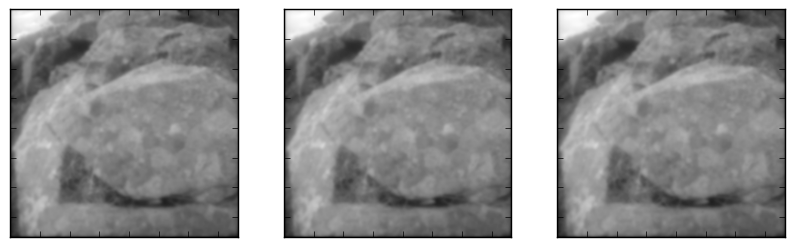

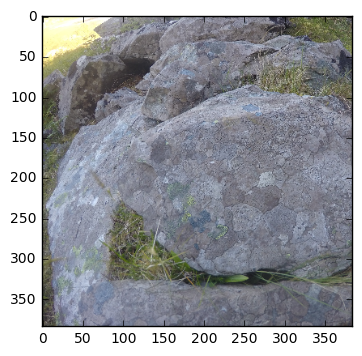

miniG0379052.tif
(126, 384, 384, 3)
(126, 384, 384, 3)
miniG0338965.tif
(127, 384, 384, 3)
(127, 384, 384, 3)
miniGOPR9068.tif
(128, 384, 384, 3)
(128, 384, 384, 3)
miniGOPR9002.tif
(129, 384, 384, 3)
(129, 384, 384, 3)
miniGOPR9047.tif
(130, 384, 384, 3)
(130, 384, 384, 3)
miniGOPR8999.tif
(131, 384, 384, 3)
(131, 384, 384, 3)
miniGOPR9058.tif
(132, 384, 384, 3)
(132, 384, 384, 3)
miniG0358994.tif
(133, 384, 384, 3)
(133, 384, 384, 3)
miniGOPR9136.tif
(134, 384, 384, 3)
(134, 384, 384, 3)
miniGOPR9057.tif
(135, 384, 384, 3)
(135, 384, 384, 3)
miniGOPR9014.tif
(136, 384, 384, 3)
(136, 384, 384, 3)
miniGOPR9323.tif
(137, 384, 384, 3)
(137, 384, 384, 3)
miniGOPR9330.tif
(138, 384, 384, 3)
(138, 384, 384, 3)
miniGOPR9074.tif
(139, 384, 384, 3)
(139, 384, 384, 3)
miniGOPR9073.tif
(140, 384, 384, 3)
(140, 384, 384, 3)
miniGOPR9036.tif
(141, 384, 384, 3)
(141, 384, 384, 3)
miniGOPR9109.tif
(142, 384, 384, 3)
(142, 384, 384, 3)
miniGOPR9010.tif
(143, 384, 384, 3)
(143, 384, 384, 3)
miniGOPR90

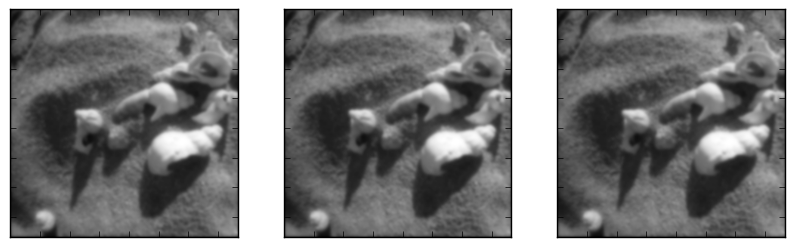

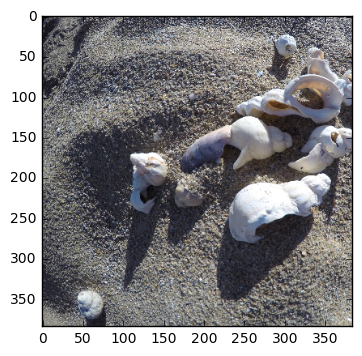

miniGOPR9024.tif
(151, 384, 384, 3)
(151, 384, 384, 3)
miniGOPR9351.tif
(152, 384, 384, 3)
(152, 384, 384, 3)
miniGOPR9062.tif
(153, 384, 384, 3)
(153, 384, 384, 3)
miniGOPR9083.tif
(154, 384, 384, 3)
(154, 384, 384, 3)
miniGOPR9070.tif
(155, 384, 384, 3)
(155, 384, 384, 3)
miniGOPR9016.tif
(156, 384, 384, 3)
(156, 384, 384, 3)
miniGOPR9089.tif
(157, 384, 384, 3)
(157, 384, 384, 3)
miniGOPR9333.tif
(158, 384, 384, 3)
(158, 384, 384, 3)
miniGOPR9053.tif
(159, 384, 384, 3)
(159, 384, 384, 3)
miniGOPR9038.tif
(160, 384, 384, 3)
(160, 384, 384, 3)
miniGOPR9107.tif
(161, 384, 384, 3)
(161, 384, 384, 3)
miniGOPR9085.tif
(162, 384, 384, 3)
(162, 384, 384, 3)
miniGOPR9134.tif
(163, 384, 384, 3)
(163, 384, 384, 3)
miniGOPR9099.tif
(164, 384, 384, 3)
(164, 384, 384, 3)
miniGOPR9008.tif
(165, 384, 384, 3)
(165, 384, 384, 3)
miniGOPR9115.tif
(166, 384, 384, 3)
(166, 384, 384, 3)
miniG0338960.tif
(167, 384, 384, 3)
(167, 384, 384, 3)
miniGOPR9018.tif
(168, 384, 384, 3)
(168, 384, 384, 3)
miniGOPR90

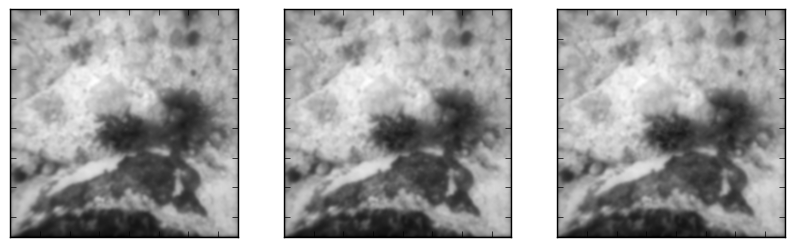

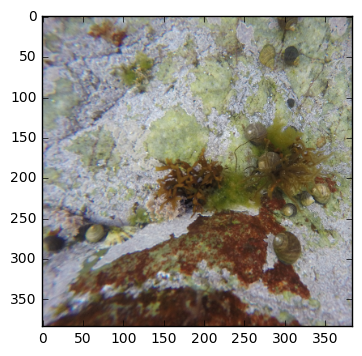

miniGOPR9114.tif
(176, 384, 384, 3)
(176, 384, 384, 3)
miniGOPR9320.tif
(177, 384, 384, 3)
(177, 384, 384, 3)
miniGOPR9060.tif
(178, 384, 384, 3)
(178, 384, 384, 3)
miniG0338962.tif
(179, 384, 384, 3)
(179, 384, 384, 3)
miniGOPR9075.tif
(180, 384, 384, 3)
(180, 384, 384, 3)
miniGOPR9342.tif
(181, 384, 384, 3)
(181, 384, 384, 3)
miniGOPR9056.tif
(182, 384, 384, 3)
(182, 384, 384, 3)
miniGOPR9130.tif
(183, 384, 384, 3)
(183, 384, 384, 3)
miniGOPR9338.tif
(184, 384, 384, 3)
(184, 384, 384, 3)
miniGOPR9054.tif
(185, 384, 384, 3)
(185, 384, 384, 3)
miniGOPR9103.tif
(186, 384, 384, 3)
(186, 384, 384, 3)
miniG0338955.tif
(187, 384, 384, 3)
(187, 384, 384, 3)


In [34]:
myMiniDir = os.listdir('./miniImgs/')
cSpher = 0
nStk = 3
off = 0
defAtt = 9e3
myTargets = []
myImgs = []

#note cv2 to color function for displaying RGB images
#opencv store images as BGR instead of RGB, so we have to fix it
#cv2.cvtColor(myImg, cv2.COLOR_BGR2RGB)
myC = 0 
for k in myMiniDir:
    myC = myC+1 
    #myImg = cv2.imread('./miniImgs/' + str(c))
    print(k)
    #Compute cuttlevision
    imgStk, PSFStk = cuttleVision(cSpher,'./miniImgs/'+str(k),nStk,off,defAtt)
    #Load target image
    myImg = cv2.imread('./miniImgs/'+str(k))
    myImgs.append(imgStk)
    myTargets.append(myImg)
    
    if (( myC % 25)==0):
        myFig, myAxes = plt.subplots(1,3,figsize=(10,10))
        for c in range(0,4):
            #for x in range(0,3):
            #plt.subplot(3,3,c+1)
            if(c < 3):
                myAxes[c].imshow(imgStk[:,:,c],cmap="gray")
                myAxes[c].set_xticklabels([])
                myAxes[c].set_yticklabels([])
            else:
                plt.figure()
                plt.imshow(cv2.cvtColor(myImg, cv2.COLOR_BGR2RGB))
                #myAxes[c].set_xticklabels([])
                #myAxes[c].set_yticklabels([])
            #plt.tight_layout()
        
    
    plt.show()
    
print("Target vector shape: ", np.shape(myTargets))
print("Training vector shape: ", np.shape(myImgs))
            
        
                                           

In [55]:
np.shape(myImgs[12])

(384, 384, 3)

In [58]:
# Allocate training/validation/test sets
trainSet = []
validSet = []
testSet = []
trainSetTgts = []
validSetTgts = []
testSetTgts = []
if(0):
    #use a seed if performance is confusing later 
    np.random.seed(1)

for ck in range(0,np.shape(myImgs)[0]):
    myRand = np.random.random()
    if (myRand <0.8):
        trainSet.append(myImgs[int(ck)])
        trainSetTgts.append(myTargets[ck])
    elif(myRand<0.9):
        validSet.append(myImgs[ck])
        validSetTgts.append(myTargets[ck])
    else:
        testSet.append(myImgs[ck])
        testSetTgts.append(myTargets[ck])
print("shape of training set: ", np.shape(trainSet),np.shape(trainSetTgts))
print("shape of validation set: ", np.shape(validSet),np.shape(validSetTgts))
print("shape of test set: ", np.shape(testSet),np.shape(testSetTgts))

shape of training set:  (150, 384, 384, 3) (150, 384, 384, 3)
shape of validation set:  (23, 384, 384, 3) (23, 384, 384, 3)
shape of test set:  (14, 384, 384, 3) (14, 384, 384, 3)


# Everything below this point is deprecated (2017/05/23)

In [7]:
#Everything below this point is deprecated
fN = './miniImgs/miniSea_Cotton.tif'

myTgt = cv2.imread(fN)
if(0): #Can't figure out why the colors are mixed up when displayed, imwrite works fine
    myTgtR = myTgt[:,:,0]
    myTgtG = myTgt[:,:,1]
    myTgtB = myTgt[:,:,2]
    myTG = np.zeros(np.shape(myTgt))
    myTG[:,:,0] = myTgtR
    myTG[:,:,1] = myTgtG
    myTG[:,:,2] = myTgtB
    print(np.shape(myTG))

cSpher = 0
nStk = 3
off = 0
defAtt = 1e-11
imgStk, PSFStk = cuttleVision(cSpher,fN,nStk,off,defAtt)
plt.figure()
plt.imshow(myTgt)
plt.show()
plt.figure(figsize = (8,8))
plt.subplot(131)
plt.imshow(imgStk[:,:,0],cmap = "gray")
plt.subplot(132)
plt.imshow(imgStk[:,:,1],cmap = "gray")
plt.subplot(133)
plt.imshow(imgStk[:,:,2],cmap = "gray")
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: './miniImgs/miniSea_Cotton.tif'

In [ ]:
print(np.shape(myImg))

In [ ]:
cSpher = 0
fN = './imgs/Sea_Cotton.jpg'
nStk = 3
off = 0
defAtt = 9
imgStk, PSFStk = cuttleVision(cSpher,fN,nStk,off,defAtt)

In [ ]:
print(np.shape(imgStk))
print(np.shape(PSFStk))
myFig, myAxes = plt.subplots(3,3,figsize=(10,10))
for c in range(0,3):
    for x in range(0,3):
    #plt.subplot(3,3,c+1)
        myAxes[c,x].imshow(imgStk[:,:,c*3+x],cmap="gray")
        myAxes[c,x].set_xticklabels([])
        myAxes[c,x].set_yticklabels([])
        plt.tight_layout()
    
myFigPSF,myAxesPSF =  plt.subplots(3,3,figsize=(10,10))
for c in range(0,3):
    for x in range(0,3):
        myAxesPSF[c,x].imshow(PSFStk[:,:,c*3+x],cmap="gray")
        myAxesPSF[c,x].set_xticklabels([])
        myAxesPSF[c,x].set_yticklabels([])
        plt.tight_layout()
                        
        
   
plt.show()


In [ ]:
import cv2


fN = './imgs/Sea_Cotton.jpg'
myImg = cv2.imread(fN)
myImg = myImg[0:624,0:624]
myImg2 = cv2.resize(myImg,None,fx=1/2, fy=1/2, interpolation = cv2.INTER_CUBIC)

plt.figure()
plt.imshow(myImg)
plt.figure()
plt.imshow(myImg2)
plt.show()
cv2.imwrite('minSea_Cotton.png',myImg2)

In [ ]:
cSpher = 0
fN = './minSea_Cotton.png'
nStk = 3
off = 0
defAtt = 9e6
cuttleVision(cSpher,fN,nStk,off,defAtt)